In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Data Preprocessing

In [2]:
interaction_pairs = []
with open('interactions_data.txt', 'r') as file:
    for line in file:
        pdb_id1, pdb_id2, interaction = line.strip().split()
        interaction = int(interaction)
        interaction_pairs.append((pdb_id1.upper(), pdb_id2.upper(), interaction))


In [3]:
# Path to the folder containing embeddings
EMBEDDING_FOLDER = 'protein_embeddings'

# Dictionary to store embeddings per PDB ID
embedding_dict_pdb_only = {}

# List all embedding files
embedding_files = [f for f in os.listdir(EMBEDDING_FOLDER) if f.endswith('.pt')]

# Build mapping from PDB ID to embedding (selecting smallest embedding)
for filename in embedding_files:
    # Extract PDB ID and chain ID from filename
    basename = os.path.splitext(filename)[0]
    if '_' in basename:
        pdb_id, chain_id = basename.split('_')
    else:
        pdb_id = basename
        chain_id = ''
    
    # Load the embedding onto CPU
    embedding_path = os.path.join(EMBEDDING_FOLDER, filename)
    embedding = torch.load(embedding_path, map_location='cpu')  # Load onto CPU

    # Ensure embedding is a tensor
    if not isinstance(embedding, torch.Tensor):
        print(f"Invalid embedding for {pdb_id}_{chain_id}")
        continue
    
    # Check if the PDB ID is already in the dictionary
    if pdb_id not in embedding_dict_pdb_only:
        # Add the embedding to the dictionary
        embedding_dict_pdb_only[pdb_id] = embedding
    else:
        # If multiple chains, select the smallest embedding (shortest sequence)
        current_embedding = embedding_dict_pdb_only[pdb_id]
        if embedding.numel() < current_embedding.numel():
            embedding_dict_pdb_only[pdb_id] = embedding


/tmp/ipykernel_2427559/3743286480.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embedding = torch.load(embedding_path, map_location='cpu')  # Load onto CPU


In [4]:
X = []
y = []

missing_embeddings = set()
total_pairs = len(interaction_pairs)

for pdb_id1, pdb_id2, interaction in tqdm(interaction_pairs, desc="Processing pairs"):
    # Check if embeddings for both PDB IDs are available
    if pdb_id1 in embedding_dict_pdb_only and pdb_id2 in embedding_dict_pdb_only:
        # Retrieve embeddings
        embedding1 = embedding_dict_pdb_only[pdb_id1]
        embedding2 = embedding_dict_pdb_only[pdb_id2]
        
        # Concatenate embeddings
        combined_embedding = torch.cat((embedding1, embedding2), dim=0)
        
        # Append to the list
        X.append(combined_embedding)
        y.append(interaction)
    else:
        # Record missing embeddings
        if pdb_id1 not in embedding_dict_pdb_only:
            missing_embeddings.add(pdb_id1)
        if pdb_id2 not in embedding_dict_pdb_only:
            missing_embeddings.add(pdb_id2)

print(f"Total pairs processed: {len(X)}")
print(f"Total pairs missing embeddings: {total_pairs - len(X)}")
print(f"Number of unique proteins missing embeddings: {len(missing_embeddings)}")


Processing pairs: 100%|██████████| 10004/10004 [00:00<00:00, 103921.90it/s]

Total pairs processed: 9806
Total pairs missing embeddings: 198
Number of unique proteins missing embeddings: 29


In [5]:
class ProteinInteractionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx].float()  # Convert to float32
        y = self.y[idx]
        return x, y

In [6]:
# NORMALIZE DATA
from sklearn.preprocessing import StandardScaler

# Collect all embeddings into a single tensor
all_embeddings = torch.stack([x.cpu() for x in X])

# Convert to NumPy for normalization
all_embeddings_np = all_embeddings.numpy()

# Split the data into train, validation, and test sets before normalization
X_train_np, X_temp_np, y_train, y_temp = train_test_split(
    all_embeddings_np, y, test_size=0.2, random_state=42
)  # 80% train, 20% temp
X_val_np, X_test_np, y_val, y_test = train_test_split(
    X_temp_np, y_temp, test_size=0.5, random_state=42
)  # 10% val, 10% test

print(f"Training examples: {len(X_train_np)}")
print(f"Validation examples: {len(X_val_np)}")
print(f"Test examples: {len(X_test_np)}")

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data to prevent data leakage
scaler.fit(X_train_np)

# Transform the datasets
X_train_scaled_np = scaler.transform(X_train_np)
X_val_scaled_np = scaler.transform(X_val_np)
X_test_scaled_np = scaler.transform(X_test_np)

# Convert the normalized NumPy arrays back to torch tensors
X_train_scaled = torch.tensor(X_train_scaled_np, dtype=torch.float32)
X_val_scaled = torch.tensor(X_val_scaled_np, dtype=torch.float32)
X_test_scaled = torch.tensor(X_test_scaled_np, dtype=torch.float32)

# Convert labels to torch tensors
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


# # Update the dataset with normalized embeddings
# dataset = ProteinInteractionDataset(X_normalized, y)


Training examples: 7844
Validation examples: 981
Test examples: 981


In [7]:
# Define lengths for train, validation, and test sets
# total_size = len(dataset)
# train_size = int(0.8 * total_size)
# val_size = int(0.1 * total_size)
# test_size = total_size - train_size - val_size

# # Split the dataset
# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset = ProteinInteractionDataset(X_train_scaled, y_train_tensor)
val_dataset = ProteinInteractionDataset(X_val_scaled, y_val_tensor)
test_dataset = ProteinInteractionDataset(X_test_scaled, y_test_tensor)

def log_positive_negative_counts(y_set, set_name):
    pos_count = np.sum(y_set)
    neg_count = len(y_set) - pos_count
    print(f"{set_name} Set - Positive Examples: {int(pos_count)}, Negative Examples: {int(neg_count)}")

# Log counts
log_positive_negative_counts(y_train, "Train")
log_positive_negative_counts(y_val, "Validation")
log_positive_negative_counts(y_test, "Test")

print(f"Training examples: {len(train_dataset)}")
print(f"Validation examples: {len(val_dataset)}")
print(f"Test examples: {len(test_dataset)}")

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Train Set - Positive Examples: 3895, Negative Examples: 3949
Validation Set - Positive Examples: 498, Negative Examples: 483
Test Set - Positive Examples: 525, Negative Examples: 456
Training examples: 7844
Validation examples: 981
Test examples: 981


/tmp/ipykernel_2427559/2661065925.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/tmp/ipykernel_2427559/2661065925.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


In [8]:
input_dim = X[0].shape[0]
print(f"Input dimension: {input_dim}")


Input dimension: 3072


In [9]:
import torch
import torch.nn as nn

class PPIClassifier(nn.Module):
    def __init__(self, input_dim):
        super(PPIClassifier, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5)
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5)
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5)
        )
        
        self.layer4 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5)
        )
        
        self.layer5 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5)
        )
        
        self.output_layer = nn.Sequential(
            nn.Linear(64, 1),
            nn.Sigmoid()  # For binary classification
        )
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.output_layer(x)
        return x


In [10]:
model = PPIClassifier(input_dim).to(device)
print(model)


PPIClassifier(
  (layer1): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer4): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slo

In [11]:
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [12]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example of how to use this function during your training loop:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


num_epochs = 20

# Inside the training loop
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)  # Reshape labels to (batch_size, 1)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Statistics
        train_loss += loss.item() * inputs.size(0)
        predicted = (outputs >= 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    # Calculate average loss and accuracy
    train_loss /= len(train_dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            predicted = (outputs >= 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    val_loss /= len(val_dataset)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/30 - Train Loss: 0.3306, Train Acc: 0.8630, Val Loss: 0.2414, Val Acc: 0.9134
Epoch 2/30 - Train Loss: 0.1961, Train Acc: 0.9278, Val Loss: 0.1878, Val Acc: 0.9337
Epoch 3/30 - Train Loss: 0.1634, Train Acc: 0.9416, Val Loss: 0.1627, Val Acc: 0.9470
Epoch 4/30 - Train Loss: 0.1352, Train Acc: 0.9532, Val Loss: 0.1390, Val Acc: 0.9602
Epoch 5/30 - Train Loss: 0.1218, Train Acc: 0.9586, Val Loss: 0.1832, Val Acc: 0.9450
Epoch 6/30 - Train Loss: 0.1213, Train Acc: 0.9575, Val Loss: 0.1543, Val Acc: 0.9531
Epoch 7/30 - Train Loss: 0.1025, Train Acc: 0.9670, Val Loss: 0.1844, Val Acc: 0.9450
Epoch 8/30 - Train Loss: 0.0984, Train Acc: 0.9679, Val Loss: 0.1399, Val Acc: 0.9592
Epoch 9/30 - Train Loss: 0.0860, Train Acc: 0.9704, Val Loss: 0.1480, Val Acc: 0.9521
Epoch 10/30 - Train Loss: 0.0893, Train Acc: 0.9716, Val Loss: 0.1606, Val Acc: 0.9531
Epoch 11/30 - Train Loss: 0.0888, Train Acc: 0.9732, Val Loss: 0.1555, Val Acc: 0.9562
Epoch 12/30 - Train Loss: 0.0931, Train Acc: 0.9669,

In [13]:
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item() * inputs.size(0)
        predicted = (outputs >= 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_loss /= len(test_dataset)
test_acc = correct / total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test Loss: 0.0865
Test Accuracy: 0.9755


In [14]:
from sklearn.metrics import classification_report, confusion_matrix

# Collect all predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)
        
        outputs = model(inputs)
        predicted = (outputs >= 0.5).float()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)


              precision    recall  f1-score   support

         0.0     0.9519    0.9978    0.9743       456
         1.0     0.9980    0.9562    0.9767       525

    accuracy                         0.9755       981
   macro avg     0.9749    0.9770    0.9755       981
weighted avg     0.9766    0.9755    0.9756       981

Confusion Matrix:
[[455   1]
 [ 23 502]]


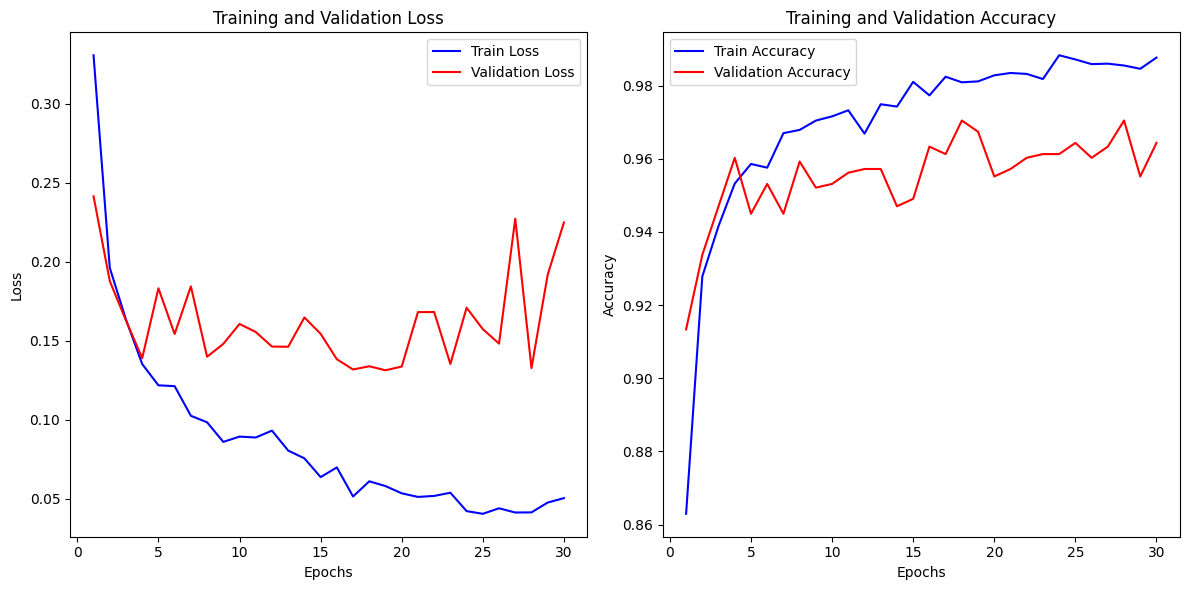

In [15]:
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)